
# BCW notebook

In [ ]:
# Cell 1
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'breast-cancer-wisconsin/wdbc.data', header=None)

In [ ]:
# Cell 2
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
# Cell 3
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=1)

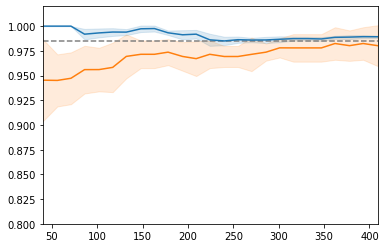

In [ ]:
# Cell 4
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1,
                                           solver='lbfgs', max_iter=10000))

N, train_lc, val_lc = learning_curve(pipe_lr,
                                     X_train, y_train, cv=10,
                                     train_sizes=np.linspace(0.1, 1, 25))

plt.plot(N, np.mean(train_lc, 1))
plt.plot(N, np.mean(val_lc, 1))
plt.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
              color='gray', linestyle='dashed')

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
train_mean = np.mean(train_lc, 1)
train_std = np.std(train_lc, 1)
plt.fill_between(N, train_mean + train_std, train_mean - train_std, 
                 alpha=0.15, color=colors[0])

test_mean = np.mean(val_lc, 1)
test_std = np.std(val_lc, 1)
plt.fill_between(N, test_mean + test_std, test_mean - test_std, 
                 alpha=0.15, color=colors[1])

plt.ylim(0.8, 1.02)
plt.xlim(N[0], N[-1]);

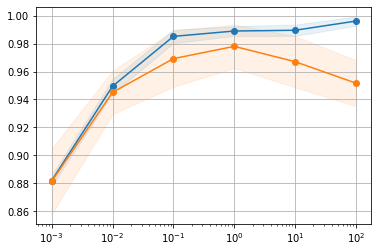

In [ ]:
# Cell 5
from sklearn.model_selection import GridSearchCV

param_range = np.logspace(-3, 2, 6)

params = {'logisticregression__C': param_range}

gs = GridSearchCV(pipe_lr, params, return_train_score=True)
gs.fit(X_train, y_train)

train_scores_mean = gs.cv_results_['mean_train_score']
train_scores_std = gs.cv_results_['std_train_score']
test_scores_mean = gs.cv_results_['mean_test_score']
test_scores_std = gs.cv_results_['std_test_score']

plt.semilogx(param_range, train_scores_mean, marker='o')
plt.semilogx(param_range, test_scores_mean, marker='o')

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.fill_between(param_range, train_scores_mean + train_scores_std,
                 train_scores_mean - train_scores_std, alpha=0.1,
                 color=colors[0], label='train +/- std')

plt.fill_between(param_range, test_scores_mean + test_scores_std,
                 test_scores_mean - test_scores_std, alpha=0.1,
                 color=colors[1], label='test +/- std')
plt.grid();

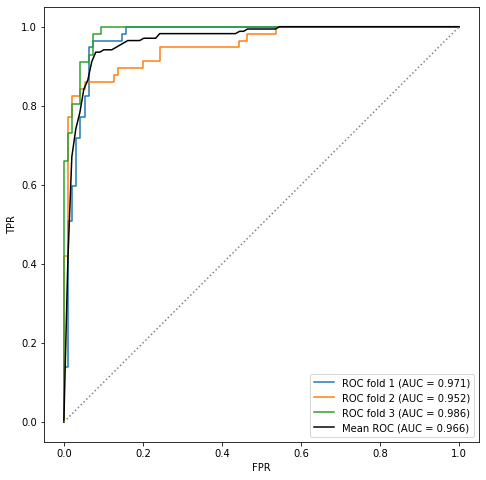

In [ ]:
# Cell 6
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=1),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0)
                        )

X_train2 = X_train[:, [2, 12]]
X_train2 = X_train
    
cv = list(StratifiedKFold(n_splits=3).split(X_train2, y_train))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold {} (AUC = {:0.3f})'.format(i+1, roc_auc))

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.gcf().set_size_inches([8,8])
plt.plot(mean_fpr, mean_tpr, label='Mean ROC (AUC = {:0.3f})'.format(mean_auc), color='k')
plt.plot([0, 1], [0, 1], linestyle=':', color='gray')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.gca().set_aspect('equal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right");